[View in Colaboratory](https://colab.research.google.com/github/roman807/TGS_Salt/blob/master/unet_10_07_6pm.ipynb)

In [0]:
import numpy as np
import pandas as pd
from keras.models import Model
from keras import optimizers
from keras import backend as K
from sklearn.metrics import confusion_matrix
from google.colab import files
import tensorflow as tf
import cv2
import os
import json
import zipfile
import skimage.io as io
import skimage.transform as trans
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import h5py

In [0]:
##### Use kaggle API

!pip install kaggle
api_token = {"username":"romanm87","key":"daa9da19c31bf091978760ad6eb373f3"}

os.chdir('/')
!mkdir ~/.kaggle #kaggle API searches in root directory for .kaggle/kaggle.json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

# API link from Kaggle:
!kaggle competitions download -c tgs-salt-identification-challenge

zip_ref = zipfile.ZipFile('train.zip', 'r')
zip_ref.extractall()
zip_ref.close()

    100% |████████████████████████████████| 61kB 2.6MB/s 
    100% |████████████████████████████████| 235kB 5.4MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/44/2c/df/22a6eeb780c36c28190faef6252b739fdc47145fd87a6642d4
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify
  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 59.4MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 68.5MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 114MB/s]
 96% 157M/163M [00:01<00:00, 112MB/s] 
100% 163M/163M [00:01<00:00, 105MB/s]
 71% 27.0M/37.9M [00:00<00:00, 59.8MB/s]
100% 37.9M/37.9M [00:00<00:00, 148MB/s] 


In [0]:
##### Prepare data and model
tr_image_dir = os.chdir('/images')
train_im = os.listdir(tr_image_dir)
x = np.array([np.array(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) for p in train_im]) / 255

tr_masks_dir = os.chdir('/masks')
train_ma = os.listdir(tr_masks_dir)
y = np.array([np.array(cv2.imread(p, cv2.IMREAD_GRAYSCALE)) for p in train_ma]) / 255

# expand dimensions for CNN inout and zero padding
x = np.expand_dims(x, axis=3)
y = np.expand_dims(y, axis=3)

# split training vs validation set
train_val_split = 0.1
x_train = x[0:int(x.shape[0]*(1-train_val_split)),:,:,:]
y_train = y[0:int(y.shape[0]*(1-train_val_split)),:,:,:]
x_val = x[int(x.shape[0]*(1-train_val_split)):,:,:,:]
y_val = y[int(y.shape[0]*(1-train_val_split)):,:,:,:]

# from: https://github.com/zhixuhao/unet/blob/master/model.py
def unet(pretrained_weights = None,input_size = (101,101,1)):
    inputs = Input(input_size)
    input_padded = ZeroPadding2D(padding=((14, 13), (14, 13)))(inputs)  ## use zero padding to match dims after maxpool/upsample
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(input_padded)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), border_mode="same")(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = merge([drop4,up6], mode='concat', concat_axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    #(None, 25, 25, 256), (None, 24, 24, 256)
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    merge7 = merge([conv3,up7], mode='concat', concat_axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = merge([conv2,up8], mode='concat', concat_axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = merge([conv1,up9], mode='concat', concat_axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    crop = Cropping2D(cropping=((14, 13), (14, 13)))(conv10)

    model = Model(inputs=inputs, output=crop)

    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    #model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model



In [0]:
##### Define evaluation metrics
class MeanIoU(object):
    def __init__(self):
        super().__init__()
    def mean_iou(self, y_true, y_pred):
        # Wraps np_mean_iou method and uses it as a TensorFlow op.
        # Takes numpy arrays as its arguments and returns numpy arrays as outputs
        return tf.py_func(self.np_mean_iou, [y_true, y_pred], tf.float64)
    def np_mean_iou(self, y_true, y_pred):
        y_pred = np.round(y_pred + 0.05, 0).reshape(-1)
        y_true = y_true.reshape(-1)        
        conf = confusion_matrix(y_pred, y_true)        
        # Compute the IoU and mean IoU from the confusion matrix:
        true_positive = conf[1,1]
        false_positive = conf[1,0]
        false_negative = conf[0,1]
        # Just in case we get a division by 0, ignore/hide the error and set the value to 0
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = true_positive / (true_positive + false_positive + false_negative)
        #iou[np.isnan(iou)] = 0
        return np.mean(iou).astype(np.float64)
miou = MeanIoU()

def bin_acc05(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred + 0.05)), axis=-1)

In [0]:
##### Define model 
#model = conv_net(input_shape, num_layers, num_filters, kernel_sizes)
model = unet()
adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'binary_crossentropy', optimizer='adam', 
              metrics=[bin_acc05, miou.mean_iou])
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.6/dist-packages/keras/legacy/layers

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 640         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("cr...)`


In [0]:
##### Run model
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_val,y_val), verbose=1)

Train on 3600 samples, validate on 400 samples
Epoch 1/10
3600/3600 [==============================] - 145s 40ms/step - loss: 0.6096 - bin_acc05: 0.7372 - mean_iou: 0.0069 - val_loss: 0.5513 - val_bin_acc05: 0.7549 - val_mean_iou: 0.0000e+00
Epoch 2/10
3600/3600 [==============================] - 121s 34ms/step - loss: 0.5709 - bin_acc05: 0.7513 - mean_iou: 0.0022 - val_loss: 0.5485 - val_bin_acc05: 0.7549 - val_mean_iou: 0.0000e+00
Epoch 3/10
3600/3600 [==============================] - 121s 34ms/step - loss: 0.5303 - bin_acc05: 0.7550 - mean_iou: 0.0321 - val_loss: 0.5523 - val_bin_acc05: 0.7549 - val_mean_iou: 0.0000e+00
Epoch 4/10
3600/3600 [==============================] - 121s 34ms/step - loss: 0.4996 - bin_acc05: 0.7698 - mean_iou: 0.1336 - val_loss: 0.4859 - val_bin_acc05: 0.7477 - val_mean_iou: 0.3876
Epoch 5/10
3600/3600 [==============================] - 121s 33ms/step - loss: 0.4284 - bin_acc05: 0.8246 - mean_iou: 0.4288 - val_loss: 0.4280 - val_bin_acc05: 0.8113 - val_mea

In [0]:
##### Predict results
y_train_pred = model.predict(x_train, verbose=1)
y_val_pred = model.predict(x_val, verbose=1)

400/400 [==============================] - 4s 11ms/step


In [0]:
#print(train_ma[-30:-20])

# a=np.array([[1,0],[1,1]])
# #plt.imshow(a)
# plt.imshow(a.transpose())


['6752a6815f.png', '61321814ce.png', '0530b67189.png', 'f4ed280779.png', '09541ce79b.png', '26808abb2d.png', '6576184a08.png', 'b6aa5c7ab4.png', 'ffce5bbb9a.png', '109bccf6c6.png']


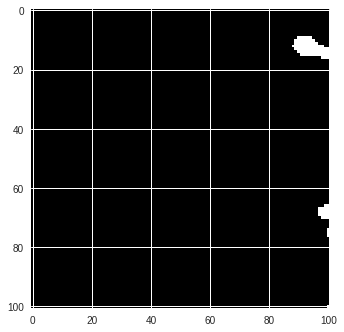

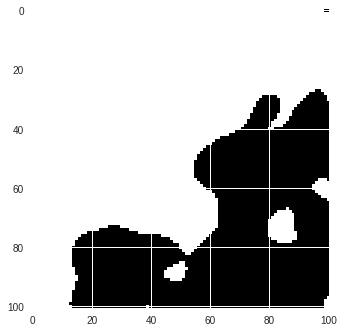

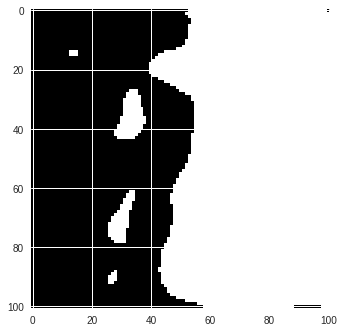

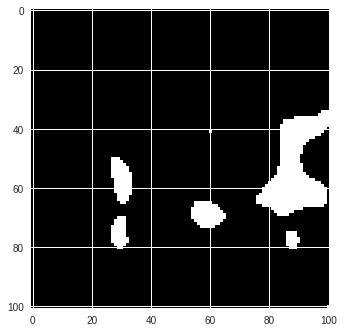

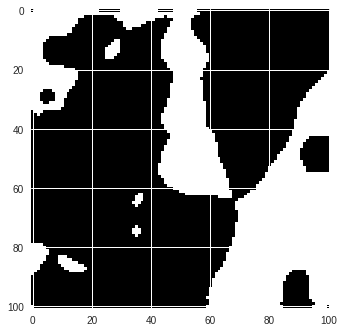

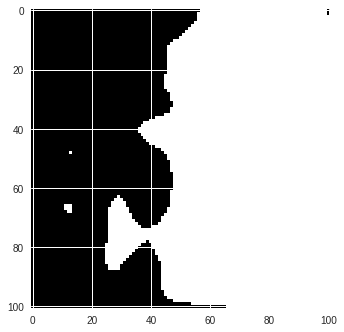

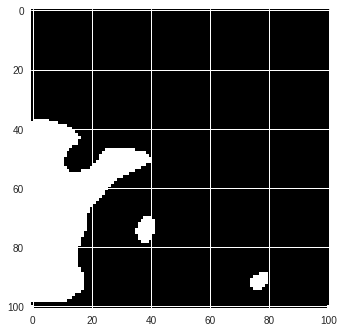

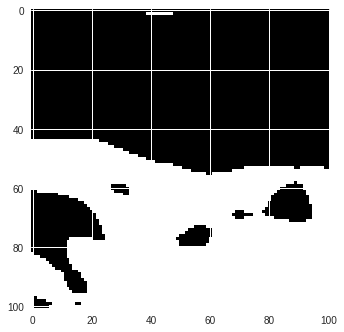

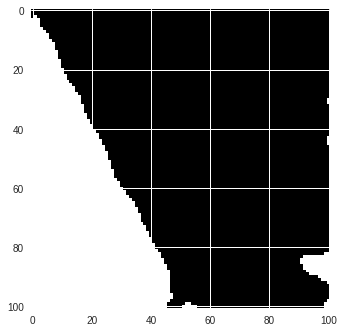

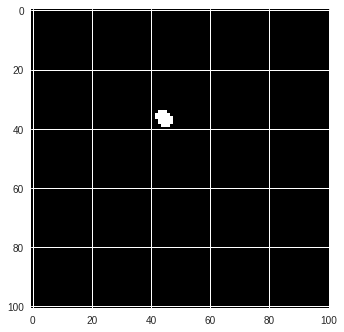

In [0]:
#print(y_train_pred.max())
#print(y_train_pred.min())
#y_val_pred.shape
#y_val_pred.shape
ims = y_val_pred[-30:-20,:,:,0]

for im in ims:
  #im = np.transpose(im)
  im = np.round(im + 0.15, 0)
  im = 1 - im
  plt.imshow(im)
  plt.show()
#print(im)
#last_10.shape
#print(train_ma[-10:-1])
#last_10
#np.round(last_10[2] + 0.2, 0)

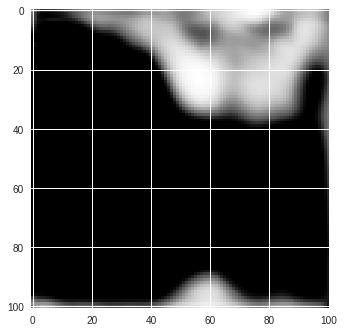

In [0]:
plt.imshow(y_val_pred[1,:,:,0])

In [0]:
###### Download results to local computer for evaluation
from google.colab import files
results_train = pd.DataFrame({'y_train': y_train.reshape(-1),'y_train_pred': y_train_pred.reshape(-1)})
results_train.to_csv("results_train.csv")
results_val = pd.DataFrame({'y_val': y_val.reshape(-1),'y_val_pred': y_val_pred.reshape(-1)})
results_val.to_csv("results_val.csv")
files.download('results_train.csv')
files.download('results_val.csv')



In [0]:
##### save / load model and weights

# https://stackoverflow.com/questions/48924165/google-colaboratory-weight-download-export-saved-models

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Save Keras Model or weights on google drive

# create on Colab directory
model.save('model.h5')    
model_file = drive.CreateFile({'title' : 'model.h5'})
model_file.SetContentFile('model.h5')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1B__N86XFsD8aRnPw_GHjdswPhVWXeckM'})

In [0]:
model.save_weights('model_weights.h5')
weights_file = drive.CreateFile({'title' : 'model_weights.h5'})
weights_file.SetContentFile('model_weights.h5')
weights_file.Upload()
drive.CreateFile({'id': weights_file.get('id')})

GoogleDriveFile({'id': '1-7fNu3ho5K-Trn8VsDKRkvxd50hGklwa'})

In [0]:
# 3. reload weights from google drive into the model

# use (get shareable link) to get file id
# https://drive.google.com/file/d/1-7fNu3ho5K-Trn8VsDKRkvxd50hGklwa/view?usp=sharing
last_weight_file = drive.CreateFile({'id': '1-7fNu3ho5K-Trn8VsDKRkvxd50hGklwa'}) 
last_weight_file.GetContentFile('last_weights.mat')
model.load_weights('last_weights.mat')